# Nodebook - Playing with PaLM 2 APIs

## Prerequisites

### Node.js modules

`sh` function to replace magic command.

In [ ]:
var { spawn } = require('child_process');
var sh = (cmd) => {
    $$.async();
    var sp = spawn(cmd, { cwd: process.cwd(), stdio: 'pipe', shell: true, encoding: 'utf-8' });
    sp.stdout.on('data', data => console.log(data.toString()));
    sp.stderr.on('data', data => console.error(data.toString()));
    sp.on('close', () => $$.done());
};

Node.js modules installation
- [esm-hook](https://www.npmjs.com/package/esm-hook) to use ESM modules with zero setup
- [dotenv](https://www.npmjs.com/package/dotenv) to load environment variables from .env file
- [google-cloud/aiplatform](https://www.npmjs.com/package/@google-cloud/aiplatform) the official binding library for VertexAI APIs
- [LangChain](https://js.langchain.com/) the Javascript version of the wellknown AI framework

In [ ]:
sh('npm install esm-hook dotenv @google-cloud/aiplatform langchain');

### Google Cloud access and authentication

- [connect](https://cloud.google.com/vertex-ai/docs/start/cloud-environment) to your environment in the the Google Cloud Console 
- If necessary [activate the VertexAI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com&_ga=2.192934826.129882004.1698758512-1325814304.1691919230)
- Create a [Service Account](https://console.cloud.google.com/projectselector/iam-admin/serviceaccounts/create?supportedpurview=project&_ga=2.259979274.129882004.1698758512-1325814304.1691919230) and an API Key: securily save the JSON file and note the location you selected for execution on Google Cloud
- Set the GOOGLE_APPLICATION_CREDENTIALS environment variable as the path and filename of the JSON file (for Jupyter I put it in the .env file where is stored this notebook)
- Install, configure, and launch the [gcloud CLI](https://cloud.google.com/sdk/docs/install)
- Run the `gcloud auth login` command and authenticate from the new opened tab in your browser

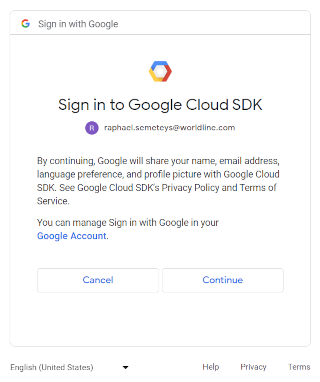

- Finally run the `gcloud auth print-access-token` command to generate an access token
- For security reasons I also stored this token in my *.env* file under the `GOOGLE_ACCESS_TOKEN` entry

I now load the token in my execution context:

In [ ]:
var dotenv = require("dotenv");
dotenv.config();

if (process.env.GOOGLE_ACCESS_TOKEN) console.log("Token loaded");

## Available APIs and Models

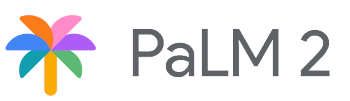

PaLM 2 offers several APIs and associated multilingual models including:
- **Text**: for text tasks that can be completed with one API response (without the need for continuous conversation)
- **Chat Text**: fine-tuned model to conduct natural multi-turn conversations
- **Text Embedding**: model embeddings for text inputs
- **Codey** models family: for code generation, chat and completion

We'll visit the image and multimodal models like imagen and gemini in an upcoming tutorial.

These models come in four sizes: Gecko, Otter, Bison and Unicorn, with Gecko being the smallest.

## Abstraction levels
There are several methods for interacting with OpenAI APIs with varying degrees of abstraction. 

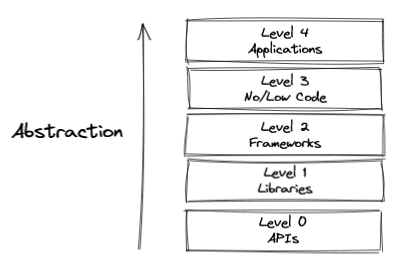

Let's visit the three first levels.

## Level 0 - Simple API calls

Let's start with level 0 of abstraction and make direct API calls like we would do with `curl`.

### Text completion

We use the text-bison model for simple text completion without conversational context. It is similar to the OpenAI Completion API (now deprecated).

Note that the model name, the project id (*fra-ai-testing-noprod* in my case), and the location selected earlier (for me: *europe-west1-b*) are in the URL.

In [ ]:
fetch("https://us-central1-aiplatform.googleapis.com/v1/projects/fra-ai-testing-noprod/locations/europe-west1-b/publishers/google/models/text-bison:predict", {
  method: 'POST',
  headers: { "Authorization": "Bearer " + process.env.GOOGLE_ACCESS_TOKEN },
  body: JSON.stringify({
      "instances": [{
          "prompt": "Say hello in Spanish"
          }],
      "parameters": {
        "temperature": 0.3,
        "maxOutputTokens": 200,
        "topP": 0.8,
        "topK": 40
      }
  })
})
  .then((response) => response.json())
  .then((json) => console.log(json.predictions[0].content));

### Chat completion

Now let's use the chat-bison model for textual chat. It is similar to the OpenAI Chat Completion API.

In [ ]:
fetch("https://us-central1-aiplatform.googleapis.com/v1/projects/fra-ai-testing-noprod/locations/europe-west1-b/publishers/google/models/chat-bison:predict", {
  method: 'POST',
  headers: { "Authorization": "Bearer " + process.env.GOOGLE_ACCESS_TOKEN },
  body: JSON.stringify({
      "instances": [{
          "messages": [{
              "author": "user",
              "content": "Why is the sky blue?"
          }],
      }],
      "parameters": {
        "temperature": 0.3,
        "maxOutputTokens": 200,
        "topP": 0.8,
        "topK": 40
      }
  })
})
  .then((response) => response.json())
  .then((json) => console.log(json.predictions[0].candidates[0].content));

## Level 1 - VertexAI Node.js module

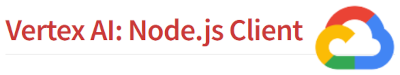

You get the general idea on how to directly call PaLM 2 APIs. Let's go up the abstraction level and use the official VertexAI Node.js module.

### Text completion

In [ ]:
// Parameters to access API
var project = 'fra-ai-testing-noprod';
var location = 'europe-west1-b';
var aiplatform = require('@google-cloud/aiplatform');
var publisher = 'google';
var model = 'text-bison@001';

// Import the Google Cloud Prediction service client
var { PredictionServiceClient } = aiplatform.v1;

// Instantiates a client
var predictionServiceClient = new PredictionServiceClient( {
  apiEndpoint: 'us-central1-aiplatform.googleapis.com',
});

// Import the helper module for converting arbitrary protobuf.Value objects.
var { helpers } = aiplatform;

async function callPredict() {
  // Configure the parent resource
  var endpoint = `projects/${project}/locations/${location}/publishers/${publisher}/models/${model}`;

  var prompt = {
    prompt:
      'Say hello in Turkish',
  };
  var instances = [ helpers.toValue(prompt) ];

  var parameter = {
    temperature: 0.2,
    maxOutputTokens: 256,
    topP: 0.95,
    topK: 40,
  };
  var parameters = helpers.toValue(parameter);

  var request = {
    endpoint,
    instances,
    parameters,
  };

  // Predict request
  var [response] = await predictionServiceClient.predict(request);
  console.log(JSON.stringify(response.predictions[0].structValue.fields.content.stringValue));
}

callPredict();

Quite a lot of code to do teh same thing as with direct API call... But note that here we use a subpart of a global module for all Google Cloud Client Libraries, so it is very generic.

### Embedding

Let's call the Embedding APi in the same way.

In [ ]:
var model = 'textembedding-gecko@001';

async function callPredict() {
  // Configure the parent resource
  var endpoint = `projects/${project}/locations/${location}/publishers/${publisher}/models/${model}`;

  var instance = {
    content: "The TechSquad is Worldline's DevRel initiative",
  };
  var instanceValue = helpers.toValue(instance);
  var instances = [instanceValue];

  var parameter = {
    temperature: 0,
    maxOutputTokens: 256,
    topP: 0,
    topK: 1,
  };
  var parameters = helpers.toValue(parameter);

  var request = {
    endpoint,
    instances,
    parameters,
  };

  // Predict request
  var [response] = await predictionServiceClient.predict(request);
  var predictions = response.predictions;
  for (var prediction of predictions) {
    console.log(prediction.structValue.fields.embeddings.structValue.fields.values.listValue.values);
  }
}

callPredict();

We get a vector of 768 dimensions as a result. Which is the size of the embedding vector space of PaLM 2.

## Level 2 - LangChain framework

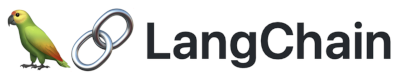

Let's simplify the code by using a higher level of abstraction provided by the [LangChain](https://js.langchain.com/) framework to call VertexAI APIs.

### Text completion

For the sale of comparison with previous code we again call the Text completion APi and the text-bison model.

In [ ]:
var { GoogleVertexAI } = require ("langchain/llms/googlevertexai");

var llm = new GoogleVertexAI({
  temperature: 0.7,
});

async function getCompletion(prompt) {
  var res = await llm.call(prompt);
  console.log(res);
}

getCompletion("Say hello in Mandarin");

Ok now the code is abstracted and LangChain have done all the heavy lifting begind the scene.

### Code completion (code-gecko model)

Time to explore the Codey family of LLM, starting with completion of code typed by the user.

In [ ]:
var llm = new GoogleVertexAI({
  model: "code-gecko",
});

async function getCompletion(prompt) {
  var res = await llm.call(prompt);
  console.log(res);
}

getCompletion("for (var co=0;");

Nice. What about code generation then?

### Code generation (code-bison model)

In [ ]:
var llm = new GoogleVertexAI({
  model: "code-bison@001",
});

async function getCompletion(prompt) {
  var res = await llm.call(prompt);
  console.log(res);
}

getCompletion("Write a function in JavaScript that checks if a year is a leap year");

### Retrieval Augmented Generation (RAG)

Earlier we called VertexAI to get embedding vectors, let's do something with them.

A particularly interesting application is using embeddings to gauge similarities between words or sentences. The idea of the RAG technique is to add new snippets of knowledge to the model by injecting them in the prompt at runtime. So before calling a Completion API, we need to first retrieve relevant information from local sources (like documents for instance) based on the user prompt.

Let's explore and implement this technique with one single PDF document.

Here we use the lightweight, in-memory and ephemeral vectorstore proposed by LangChain. The framework provides the appropriate abstraction level to implement the three listed tasks with very few instructions.

In [ ]:
var { GoogleVertexAIEmbeddings } = require ("langchain/embeddings/googlevertexai");
var { RetrievalQAChain } = require("langchain/chains");
var { MemoryVectorStore } = require ("langchain/vectorstores/memory");
var { PDFLoader } = require("langchain/document_loaders/fs/pdf");

var llm = new GoogleVertexAI({
  temperature: 0.7,
});

var embeddings = new GoogleVertexAIEmbeddings();

async function getPDFCompletion() {
  //Load our local PDF document
  var loader = new PDFLoader("TechSquad.pdf");
  var docs = await loader.load();
    
  //Create a vector store from the embeddings
  var vectorStore = await MemoryVectorStore.fromDocuments(
    docs,
    embeddings
  );
    
  // Create a chain that uses the OpenAI LLM and our vector store
  var chain = RetrievalQAChain.fromLLM(
    llm, 
    vectorStore.asRetriever()
  );
    
  var res = await chain.call({
    query: "What is the TechSquad?"
  });
    
  console.log(res.text);
}

getPDFCompletion();

The response from PaLM 2 integrates contextual information coming from the PDF file we transformed in vectors.

Cool.

We'll visit abstraction levels 3 and 4 in more upcoming videos so stay tuned!

## Thank you!